<center><h1>Asset classes</h1></center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/FIN323/Emory_small.png" height="200px" width="300px" />
</center>

In [1]:
import wrds
import pandas as pd
from matplotlib import pyplot as plt
import requests
import xmltodict
from datetime import datetime
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from fredapi import Fred

import os
from dotenv import load_dotenv
load_dotenv();

<center><h2>Asset classes</h2></center>

An asset class is a broad category of investments.

The asset classes that we will discuss the most in this course are:
- Treasuries.
    - Obligations of the United States government.
- Corporate bonds.
    - Publicly-traded senior obligations of US corporations.
- The stock market.
    - Publicly-traded junior obligations of US corporations.

All of the above are often called "traditional" asset classes, because they are the biggest components of the investment portfolio for the average US household.

Treasuries and corporate bonds with very short time to maturity (by convention, three months or less) are often grouped as a separate asset class of "cash equivalents."

There are also many other important asset classes that we will spend less time on.

- Derivatives.
    - We will briefly discuss forwards, futures, and options in Module 3.
    - We will also cover short-selling, which is similar to a derivative strategy.
- Private equity and private credit.
    - Corporate obligations that are not publicly traded.
- Real estate.
    - Actually the biggest asset for most US households (and often also called a "traditional" asset class).
    - But not easily traded, and blur the line between investment and consumption.
- Commodities and cryptocurrencies.

<center><h2>Treasuries</h2></center>

### Treasuries

- Treasuries come in different categories, reflecting different maturities:
    - Treasury bill: One year maturity or less. No coupon.
    - Treasury note: 2-10 years maturity. Semiannual coupon.
    - Treasury bond: More than ten years maturity. Semiannual coupon.
- There are also inflation-protected versions called TIPS. More on these later.

### Treasury auctions

- The Treasury auctions off many different maturities of Treasuries, almost every day.
- Each auction offers a certain amount of principal at a certain maturity.
- Participants bid a yield to maturity that they require to hold this investment.
- The lowest yield wins, and this is used to set the final terms of the security.
- Yields are like the opposite of price: A higher yield means that investors demand a higher rate of return to hold the asset. A lower yield means they are willing to accept a lower rate of return.
- The yields that come out of this process can *almost* be seen as risk-free rates of return that were available to all investors as of the auction date.
- I will come back in a few minutes and explain why this is not quite 100\% true, and what can be done about it.

### History of Treasury yields and the term spread

Corresponds to textbook Figure 15.6. [Click here to see the most recent version.](https://fred.stlouisfed.org/graph/?g=1823t)

In [2]:
%%capture
plt.rcParams['figure.figsize'] = [14.0, 7.0]

DGS10 = Fred().get_series('DGS10',observation_start='1970-01-01',frequency='m',aggregation_method='eop')
TB3MS = Fred().get_series('TB3MS',observation_start='1970-01-01',frequency='m',aggregation_method='eop')

yields_figure,ax = plt.subplots()
DGS10.plot(ax=ax,label="10-year Treasury note yield",color='tab:blue')
TB3MS.plot(ax=ax,label="90-day Treasury bill yield",color='tab:red')
(DGS10-TB3MS).plot(ax=ax,label="Spread",color='pink',linestyle='--')
ax.legend(loc='upper right')
ax.axline([0,0],[1,0],color='black',linewidth=0.5)

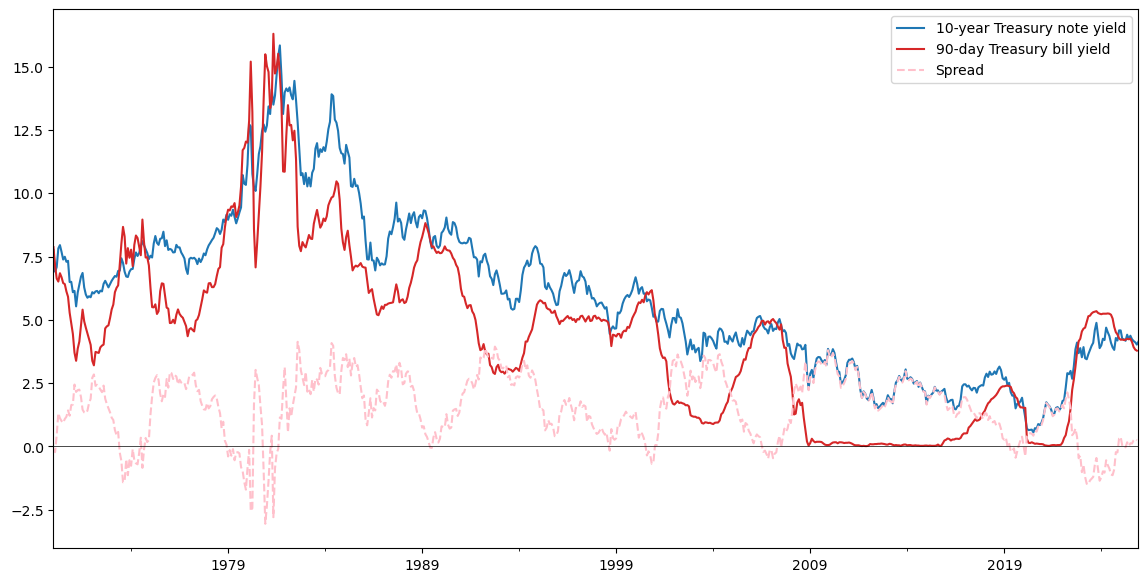

In [3]:
yields_figure

### The yield curve

Previous slide: The 3m rate has followed the same downward trend as the 10-year rate, but is much more volatile.

Next slide: Snapshot of rates set at auction during Aug 2021.

The *yield curve* is a plot of yields against maturities on a given date.

The typical pattern is that longer maturities have higher yields.
When this pattern reverses, we say the yield curve is "inverted."

In [4]:
# Code to get yields via the Treasury API. The only way to filter dates is to specify a "page" number in the URL. 
def get_treasury_yields(page_num):
    url = f'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value=all&page={page_num}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = xmltodict.parse(response.content)
        entries = data['feed']['entry']
        records = []
        for entry in entries:
            properties = entry['content']['m:properties']
            record = {
                'Date': properties['d:NEW_DATE']['#text'],
                '1Month': float(properties['d:BC_1MONTH']['#text']),
                '2Month': float(properties['d:BC_2MONTH']['#text']),
                '3Month': float(properties['d:BC_3MONTH']['#text']),
                '6Month': float(properties['d:BC_6MONTH']['#text']),
                '1Year': float(properties['d:BC_1YEAR']['#text']),
                '2Year': float(properties['d:BC_2YEAR']['#text']),
                '3Year': float(properties['d:BC_3YEAR']['#text']),
                '5Year': float(properties['d:BC_5YEAR']['#text']),
                '7Year': float(properties['d:BC_7YEAR']['#text']),
                '10Year': float(properties['d:BC_10YEAR']['#text']),
                '30Year': float(properties['d:BC_30YEAR']['#text'])
            }
            records.append(record)
        # Convert the list of records to a DataFrame
        yields = pd.DataFrame(records)
        # Convert 'Date' to datetime format
        yields['Date'] = pd.to_datetime(yields['Date'])
        # Set 'Date' as the index
        yields.set_index('Date', inplace=True)
        return yields
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

### Treasury yields as of Aug 13, 2021 from [treasury.gov](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield)

In [5]:
# Page 26 corresponds to roughly 2021-2022.
yields = get_treasury_yields(26)
print(yields.loc['2021-08-13'])

1Month    0.04
2Month    0.05
3Month    0.06
6Month    0.05
1Year     0.08
2Year     0.23
3Year     0.44
5Year     0.79
7Year     1.08
10Year    1.29
30Year    1.94
Name: 2021-08-13 00:00:00, dtype: float64


### Yield curve, August 13 2021
Plotting the numbers from above:

In [6]:
%%capture
yields_20210813 = yields.loc['2021-08-13']
yield_curve_20210813 = pd.Series(data=list(yields_20210813),index=[1/12,2/12,3/12,6/12,1,2,3,5,7,10,30])
yield_curve_figure_20210813,ax = plt.subplots()
yield_curve_20210813.plot(ax=ax,marker='o')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield on 8/13/21 (percent)')

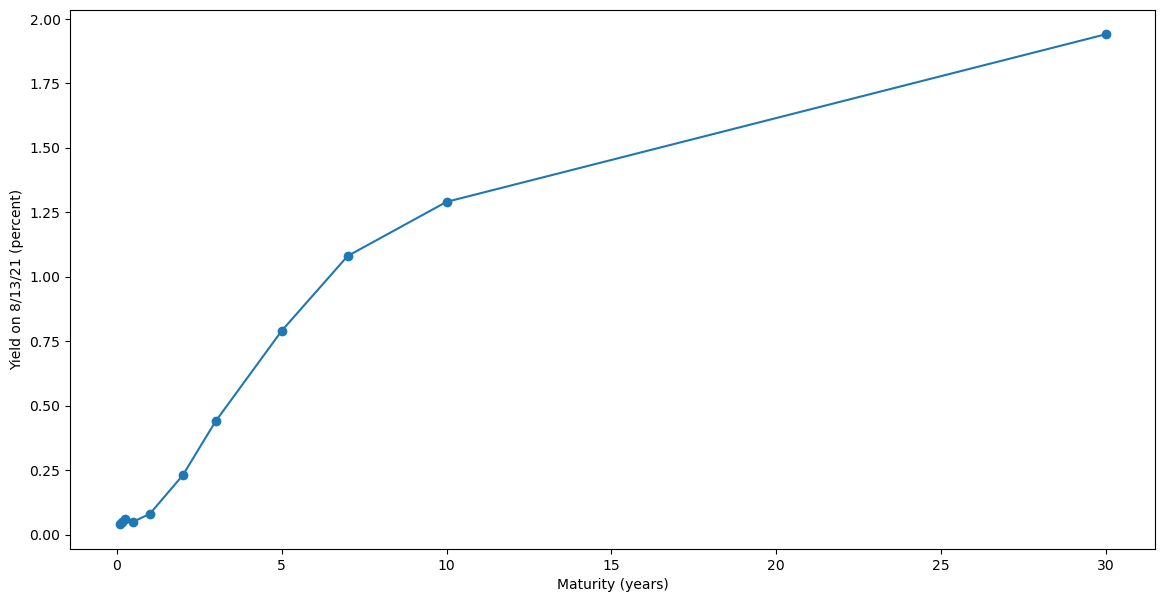

In [7]:
yield_curve_figure_20210813

### "Inverted" yield curve, July 31 2024

In [8]:
%%capture
# Page 28 is late 2024.
yields = get_treasury_yields(28)
yields_20240731 = yields.loc['2024-07-31']
yield_curve_20240731 = pd.Series(data=list(yields_20240731),index=[1/12,2/12,3/12,6/12,1,2,3,5,7,10,30])
yield_curve_20240731_figure,ax = plt.subplots()
yield_curve_20240731.plot(marker='o')
plt.xlabel('Maturity (years)')
plt.ylim(0,6)
plt.ylabel('Yield on 7/31/24 (percent)')

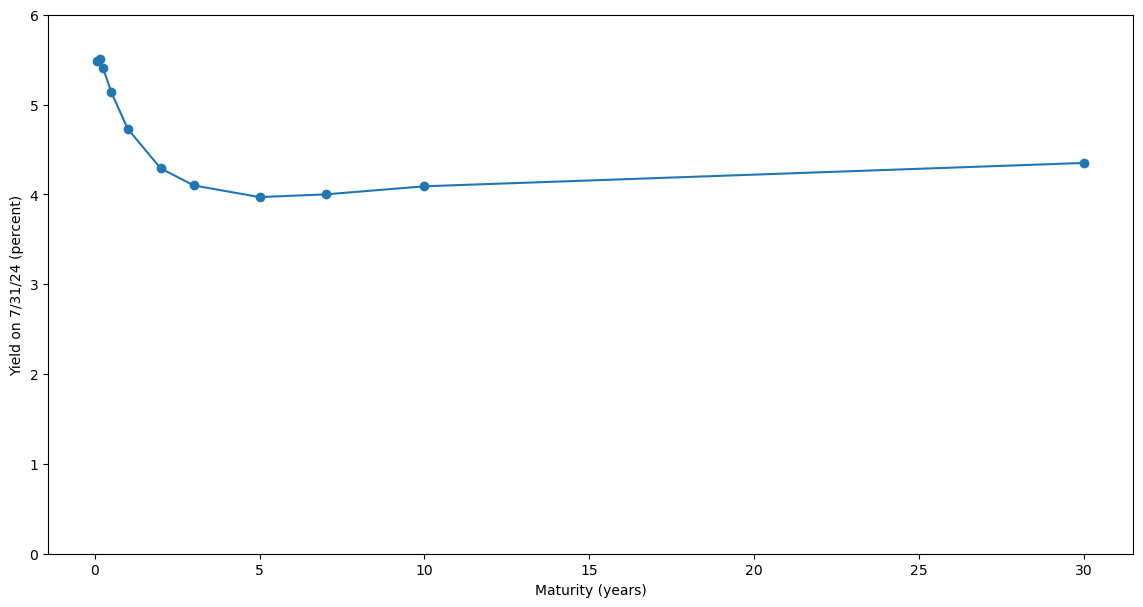

In [9]:
yield_curve_20240731_figure

### As of August 2025

In [10]:
%%capture
# Page 29 is the most recent as of late 2025.
yields = get_treasury_yields(29)
yields_20250819 = yields.loc['2025-08-19']
yield_curve_20250819 = pd.Series(data=list(yields_20250819),index=[1/12,2/12,3/12,6/12,1,2,3,5,7,10,30])
yield_curve_20250819_figure,ax = plt.subplots()
yield_curve_20250819.plot(ax=ax,marker='o')
plt.xlabel('Maturity (years)')
plt.ylim(0,6)
plt.ylabel('Yield on 8/19/25 (percent)')

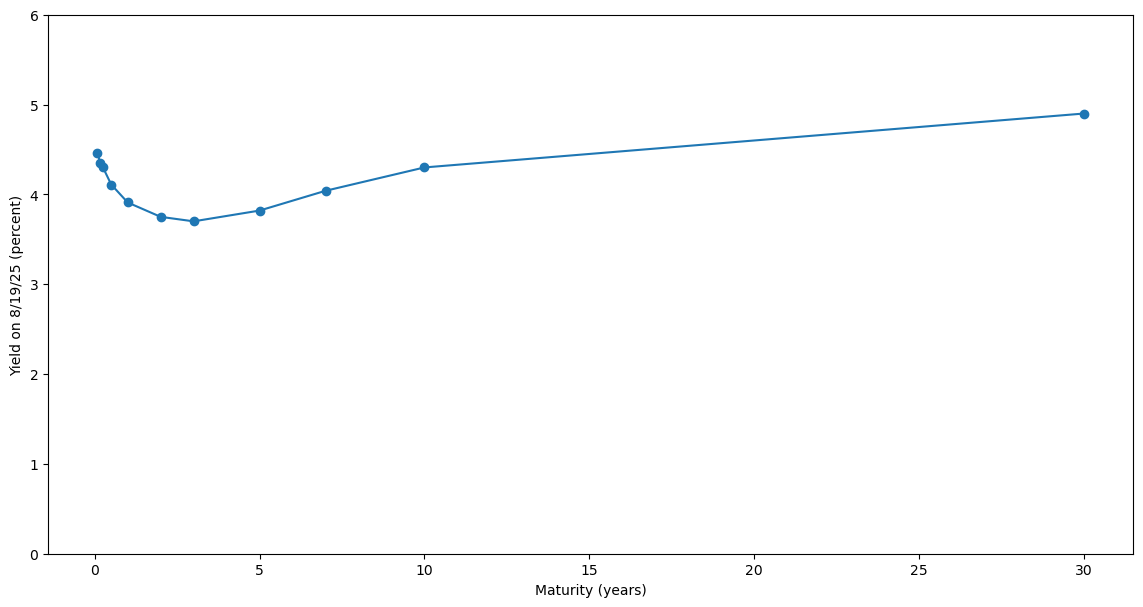

In [11]:
yield_curve_20250819_figure

### What does an inverted yield curve mean?

- A common perspective (called the “expectations hypothesis”) is that, when the yield curve inverts, the market is predicting interest rates to fall between the short and long dates.
- The argument is that otherwise, no one would hold the long-maturity bond. You would be better off buying the
short-maturity bond at higher yield, then rolling it over.
- Because the Fed often cuts rates sharply to fight recessions, an inverted yield curve often predicts recessions.
- But, rates can be expected to fall even when no recession is imminent.
- For example: As of 2025, short rates have been unusually high for a long time, as part of the Fed's response to the outbreak of inflation several years ago. Inflation has fallen and stabilized, and many market participants expect a rate cut soon. 
- Under the expectations hypothesis, this should lead to an inverted yield curve, but does not necessarily predict a recession.

### TIPS

- The government also auctions off Treasury Inflation Protected Securities (TIPS), which offer (some) inflation protection:
Their payments grow with the CPI every year.
- Other than this, TIPS are structured exactly the same as traditional Treasuries.
- Investors are clearly willing to pay more for TIPS -- that is, accept a lower yield.
- In fact, the spread in yields between TIPS and Treasuries should exactly reflect expected inflation.
- This spread is a useful indicator called *breakeven inflation*.
- Here's a [graph](https://fred.stlouisfed.org/graph/?g=Jf2U) comparing breakeven inflation with actual inflation in recent years.

### Prices and yields for Treasury bills, and short-term risk-free rates

- For Treasury bills, the yield set at auction is an actual risk-free rate available to investors.
    - (Remember: Treasury bills have one year maturity or less, and *no coupon payment*.)
- Once the auction is finished, these bills are simply sold for a price equal to the principal amount discounted by the winning yield.
- Example 1: In an auction of 1-year bills on 8/7/25, the winning yield was 3.95\%.
    - So for each \\$100 of principal, the bills were sold at a price of $\frac{\$100}{1.0395} = \$96.20$.
    - Anyone could have earned a 3.95\% **risk-free** return of 3.95\% over the year from that date.
- Example 2: Two days earlier, in an auction of 28-day bills, the winning yield was 4.364\%.
    - **Yields are always reported on an annualized basis.**
    - Over 28 days, investors required a return of $1.04364^{28/365} - 1 = 0.328\%$.
    - So for each \\$100 of principal, the bills were sold at a price of $\frac{\$100}{1.00328} = \$99.67$.
- Thankfully, most of the risk-free rates we will need in this class will be for one year or less.

### Prices and yields for Treasury notes and bonds
- How do the previous calculations work for notes and bonds, which do pay coupons?
- This will only be important a few times in our course, so I will describe at a high level.
- For notes and bonds, as with bills, the auction sets a yield to maturity on the bond.
- To be precise, the YTM is the DCF discount rate that investors apply to the bond's payments.
- That is, the YTM is the discount rate $y$ that makes this equation add up:
$$
\text{Price} = \frac{\text{Coupon}}{(1+y)^{0.5}} + \frac{\text{Coupon}}{(1+y)} + \frac{\text{Coupon}}{(1+y)^{1.5}} + \dots + \frac{\text{Coupon} + \text{Principal}}{(1+y)^T}
$$
- This is not quite a risk-free rate of return. See next slide.

### Treasury note and bond yields are *not* true risk-free rates of return...
- Example: In an auction on 8/6/25, a 10-year T-note with coupon 4.25\% was sold with a yield to maturity of 4.255\%.
- **Neither** of these was a 10-year risk-free return available to investors (though both are close).
    - The coupon is like an annual return that you earn as a percentage of *face value*.
    - The YTM is like an annual return as a percentage of *purchase price*.
    - In both cases, most of the return comes from coupons paid long before maturity.
    - You don't know in advance if you'll be able to reinvest these coupons at the same rate.
    - So neither of them is a *compound* rate of return you can lock in over the next 10 years.
- What we would really like to know is the yield on a *zero-coupon* 10-year note, so we can just do the same simple calculations as we did for the T-bills earlier. (See next slide...)

### Treasury STRIPS yields are.
- Treasury does not issue zero-coupon notes or bonds, but the private market creates them:
- Market participants buy Treasury notes and bonds, then repackage and sell the cash flows from each specific date as their own securities, called STRIPS.
- In this market, you *can* buy a zero-coupon 10-year Treasury note.
- **The yield on this security is the true risk-free rate over the next ten years.**
- It is not always easy to find out the actual prices at which STRIPS are trading.
- But we can back them out very accurately from the YTM on traditional Treasuries, through an approach called "bootstrapping the yield curve."
- Many different researchers publish their own estimates of these numbers. 
- One popular model says that the 10-year zero-coupon yield on 8/6/25 was 4.2642\% ([link](https://fred.stlouisfed.org/series/THREEFY10)).
- When I give you risk-free rates in this class, they will come from a ``zero-coupon yield curve.''

<center><h2>Corporate bonds</h2></center>

### Corporate bonds: Basic facts

Like Treasuries:
- Semiannual coupon payments until repayment of principal.
- Quoted as yield to maturity, rather than price.

Unlike Treasuries:
- Many issuers, and each may have a wide array of bonds.
    - For this reason, the bond market is more fragmented and illiquid than the stock market.
- There is a risk of default!
    - This means the *expected* return on a corporate bond is lower than its yield to maturity.
    - The yield to maturity is like an interest rate. It is a promise that the issuer might not keep.
    - You as an investor have to adjust this promise downward for the possibility of default.
    - Be careful not to compare the yield on a risky bond with average returns on other investments!
    - By convention, we label the yield on a bond as $y$ and its *expected* return as $r_D$.
    - See textbook example 14.13 for further discussion.

### The fragmented secondary market for bonds

Corporate bonds are difficult to trade:
- Unlike Treasuries, they are risky, so investors must evaluate each one carefully.
- Unlike stocks, there can be a large variety of them even for a single issuer.

Most bonds are traded “over the counter” among dealers.
- You place an order with a dealer, who must find a counterparty to take the other side, via a network that exists between them.
- This makes bond mutual funds expensive and risky to manage.

An ongoing puzzle: How to improve liquidity in this market?
- Bond exchanges have never really taken off, but may eventually.
- Bond ETFs are another potential solution, as we will discuss.

<center><h2>The stock market</h2></center>

### Corporate equity

- Just as bonds are a claim to interest and principal payments, stocks are a claim to dividend payments made by the issuer.
- But while bond payments are a legal obligation, firms are not required to declare or maintain dividends.
- Therefore stock is often called the “junior” or “residual” claim.
- On the balance sheet, stock represents the “equity” value of the company’s assets, after all liabilities including debt are satisfied. (See further discussion below.)

(Note: I am specifically talking about common stock.  
Preferred stock is more like debt, and not a major topic for this course.)

### The stock market and the investor’s portfolio

The “stock market” refers to stocks listed on public exchanges.

- The companies issuing these stocks must comply with strict disclosure and other requirements mandated by the SEC.
- Public stocks are the largest component of most investors’ portfolios, and their biggest source of both risk and return.
- They are also an easy asset class to study: We can get price data from the exchanges, and financial data about the companies from their required disclosures.

Stocks that are *not* publicly traded are called "private equity." This includes large private corporations, small closely-held businesses, and venture capital.
- Likewise, "private credit" is a catchall for corporate debt obligations that are not publicly-traded bonds nor bank loans. 

### How many exchange-traded stocks are there in the US?

In [12]:
%%capture
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])

# To build a plot of the number of listed companies and hwo that has changed over time:
# Pull CRSP stock names (monthly coverage)
# exchcd: 1=NYSE, 2=AMEX, 3=NASDAQ
# shrcd: 10=common shares, 11=non-voting common
query = """
    select permno, permco, namedt, nameenddt, shrcd, exchcd
    from crsp.stocknames
    where shrcd in (10,11) and exchcd in (1,2,3)
"""
df = conn.raw_sql(query)
conn.close()

# Expand into year range
df['start'] = pd.to_datetime(df['namedt'])
df['end'] = pd.to_datetime(df['nameenddt'].fillna('today'))

# Create yearly range for each firm
years = []
for _, row in df.iterrows():
    for yr in range(row['start'].year, row['end'].year + 1):
        years.append((row['permco'], yr))

counts = pd.DataFrame(years, columns=['permco','year'])
num_firms = counts.groupby('year')['permco'].nunique().reset_index()

# Plot
public_companies_figure,ax = plt.subplots()
num_firms[num_firms['year']>=1975].plot(ax=ax,x='year', y='permco', kind='line', title='Number of public companies in the US',legend=None)

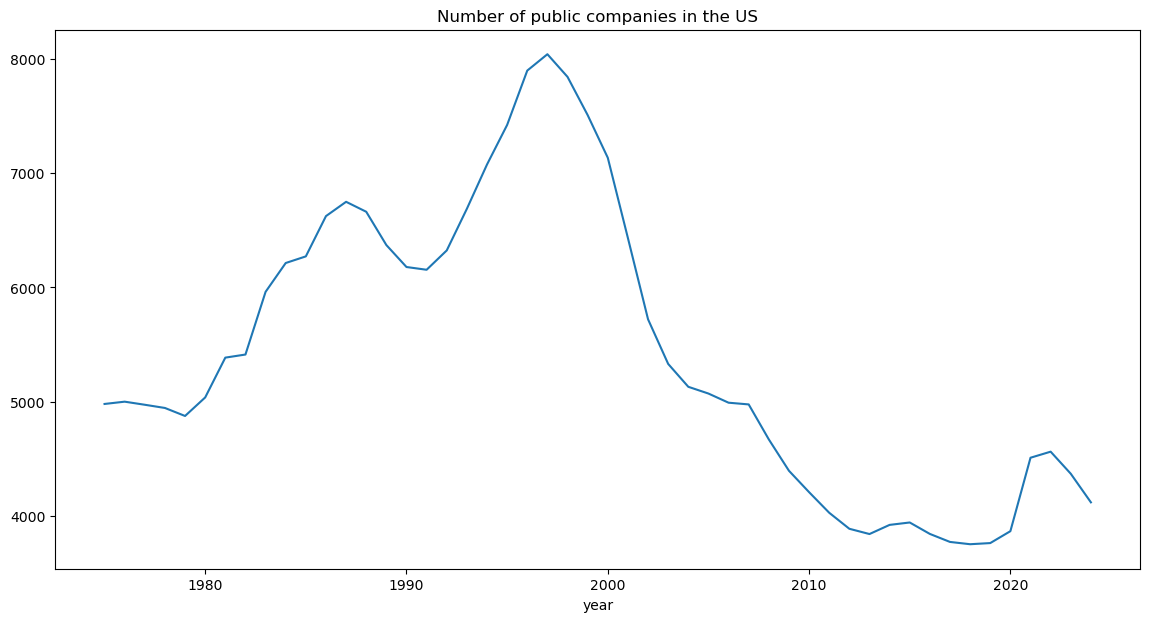

In [13]:
public_companies_figure

### Brief overview of trading stocks on an exchange

NYSE and Nasdaq are the two major US stock exchanges.
For all practical purposes, trading is electronic on both.

Orders for stocks specify desired quantities at different prices.
The exchange adjusts prices to clear as many orders as possible.

The prices you see reported are the prices of recent trades:
Someone was willing to buy at that price, someone else was
willing to sell, and the exchange cleared both of their orders.

If the value of a stock changes, traders immediately change their
orders, and the very next price will be different.

The end result is like a continuous auction throughout the day.

Most importantly, there is no opportunity to trade at old prices,
and each price reflects all available information at that point.

<center><h2>Accounting for equity value</h2></center>

### Book value of equity

"Book value" means the value at which something is carried on the firm’s balance sheet.

Journal entries will always maintain the key relationship,

<center>
Assets = Liabilities + Equity
</center>

The book value of equity is always the book value of assets, minus the book value of liabilities.

Also called “stockholders’ equity” or “shareholders’ equity.”

### Home Depot, Inc 10-K, Jan 28 2018

![](https://wgjm1986.github.io/FIN323/Module%201/Week%201%20-%20Asset%20classes/home_depot_assets.png)

### Home Depot, Inc 10-K, Jan 28 2018

![](https://wgjm1986.github.io/FIN323/Module%201/Week%201%20-%20Asset%20classes/home_depot_liabilities.png)

### Home Depot, Inc 10-K, Jan 28 2018

![](https://wgjm1986.github.io/FIN323/Module%201/Week%201%20-%20Asset%20classes/home_depot_equity.png)

"Treasury stock" reflects shares repurchased in the past.

1.78 billion shares issued - 622 million repurchased = 1.158 billion outstanding.

Book value per share is \\$1.45 bn / 1.158 bn = \\$1.25.

### Market value of equity

**Market value** is the price at which something would sell now.
- Equals book value on the date when the asset or liability is created, but will generally be different at any other date.

For stocks, the difference can be tremendous:
- In Jan 2018, Home Depot’s stock sold for \\$200 per share.
- Compare with its book value per share of \\$1.25 that we just calculated!

**Market capitalization** is the total market value of a firm’s stock.
- For Home Depot, this was \\$200 × 1.158bn = \\$232bn.
- Again, compare with \\$1.45bn of book value from earlier.

### Market capitalization vs book value of equity for Home Depot

In [14]:
%%capture
# Build figure of Home Depot's book equity vs market cap over time using Compustat data
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
HD = conn.raw_sql("""
    select gvkey, popsrc, indfmt, datafmt, consol, fyear, datadate, 
    tic, seq, csho, prcc_f
    from comp.funda
    where popsrc = 'D'
    and indfmt = 'INDL'
    and datafmt = 'STD'
    and consol = 'C'
    and gvkey = '005680'
    and datadate >= '01/01/1980' and datadate <= '12/31/2025'
    """, date_cols=['datadate'])
conn.close()

HD.set_index('datadate',inplace=True)
if HD.index.duplicated().any(): print("Warning: non-unique dates")
HD['MC'] = HD['prcc_f']*HD['csho']
HD_figure,ax = plt.subplots()
(HD['MC']/1e3).plot(ax=ax,label="Home Depot market capitalization",color='tab:blue')
(HD['seq']/1e3).plot(ax=ax,label="Home Depot book equity value",color='black')
plt.xlabel('Year')
plt.ylabel('Billions of dollars')
ax.legend(loc='upper left')

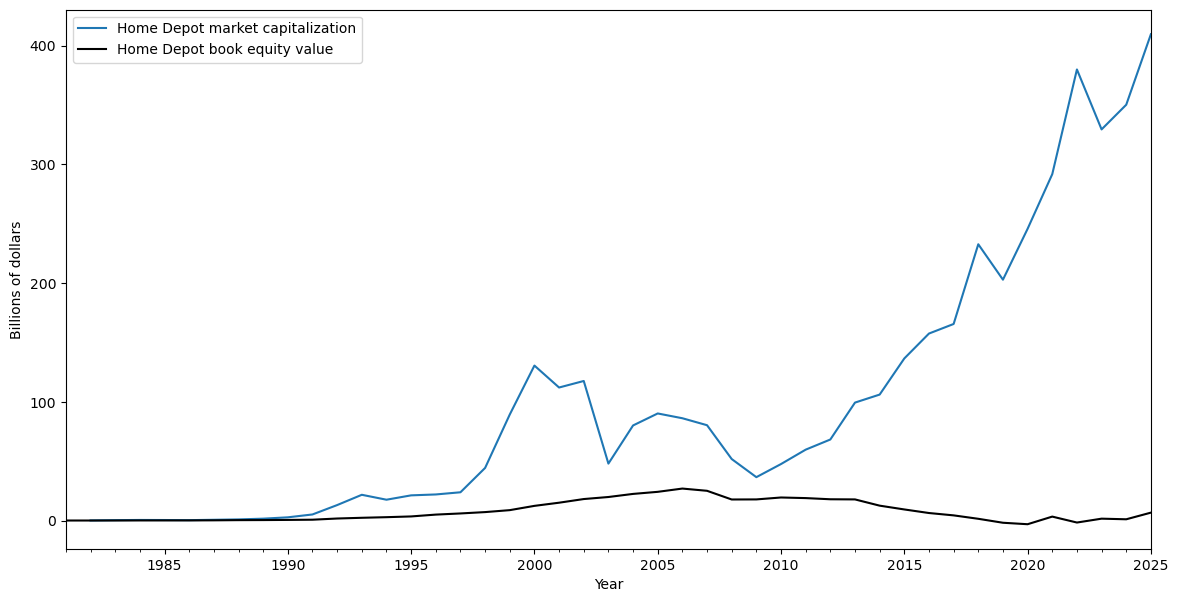

In [15]:
HD_figure

## Growth and value stocks

- Analysts often compare "growth" stocks and "value" stocks.
- Exact definitions vary, but the general idea is always the same:
    - Divide market cap by some number from financial statements.
    - Stocks with high values of this ratio are called “growth stocks.”
    - Stocks with low values are called “value stocks.”
- These labels are meant to suggest investment strategies:
    - High ratios suggest growth in future dividends.
    - Low ratios look like a cheap buying opportunity.
- ...but don’t take this too seriously. They are just labels.

## Example: Market-to-book ratio

Recall that market value of equity is usually greater than book value.
- Their ratio gives us the market-to-book ratio (MB for short).
- For example, at the end of 2018, Microsoft’s book value of equity was \\$92bn, while its market capitalization was \\$770bn.
- Its market-to-book ratio was 770/92 = 8.37.
- At the same time, Kohl’s had book value of equity \\$5.5bn, market capitalization of \\$12bn. So Kohl’s MB ratio was 2.2.

Price-to-book is another name for the same thing.

Note that you get the same ratios if you use per-share numbers.

Book-to-market (BM), or book-to-price, just divides the other way:  
BM for MSFT was 92/770 = 0.12, BM for Kohl’s was 5.5/12 = 0.46

## Price-earnings and price-dividend ratios

The price-to-earnings ratio (PE) is similar to MB:
- Market capitalization divided by the firm’s earnings;
- or, share price divided by earnings per share.

Price-dividend (PD) uses dividends instead of earnings.
- Closely linked to PE, because dividends and earnings have to add up to the same number over in the long run.

Textbook section 18.4 provides some data and figures.

Like the MB ratio, can use these for relative comparisons across firms.

But unlike MB, these ratios are also meaningful on their own: they are connected with DCF valuation. See below...

<center><h2>Valuation</h2></center>

### DCF valuation

Investments are worth the present value of expected future cash flows:

$$
P = \frac{CF_1}{1+r} + \frac{CF_2}{(1+r)^2} + \frac{CF_3}{(1+r)^3} ...
$$

- These cash flows are **expected values**: They average over every possible scenario for the future, and may grow forever.
- The DCF value is a finite number, provided the long-run average growth of cash flows is less than the required rate of return $r$.
- Discount rates should represent the “opportunity cost of capital,” which means, the average return you would get from the next-best investment that features the same level of risk.

### DCF valuation of a growing perpetuity

We can’t reliably forecast every future cash flow.  
To apply this framework, we need to simplify it.

One approach is to make a good guess about the long-run growth
rate of cash flows, call it g , and use it to forecast the future values:

$$
P = \frac{CF_1}{1+r} + \frac{CF_1\times(1+g)}{(1+r)^2} + \frac{CF_1\times(1+g)^2}{(1+r)^3} + ...
$$

Using the *growing perpetuity formula*, this magically simplifies to

$$
P = \frac{CF_1}{r - g}
$$

Most people blend these approaches: Forecast a few years, then bundle the rest into a “terminal value” using the formula above.

### Risk-free bond valuation by DCF (see p.446)

A risk-free bond delivers a fixed coupon for a number of periods $T$, then a large principal repayment at the end. Its DCF valuation is

$$
P =
\text{Coupon} \times \underbrace{ \frac{1}{r_f}\left[ 1 - \frac{1}{(1+r_f)^T}\right] }_{\text{Annuity factor}} 
        \, + \,
        \text{Principal} \times \underbrace{ \frac{1}{(1+r_f)^T} }_{\text{PV factor}}
$$

The “annuity factor” is the PV of a perpetuity starting today, minus another starting from T, using the formula from above with $g = 0$.

In practice, Treasuries are regarded as the only risk-free security, and their prices are easy to look up. So this formula is mainly used to *back out* the risk-free rate, in order to use it for other purposes. You fill in the rest of the information in the formula, and then find the value of $r_f$ that makes the formula match the actual price at which the Treasury is currently trading.

Looking carefully at the math, you can see that prices are very sensitive to changes in interest rates when $T$ is very large.
This is why interest rate risk is a major concern when you hold a long-term bond that you might want to sell before maturity.

### Risky bond valuation by DCF (see p.468-470)

There are two ways to adapt the prior slide to *risky* bonds:

- The first approach is to apply the DCF framework directly:  
Replace “Coupon” and “Principal” with expected values.
Replace $r_f$ with a higher rate $r_D$ that reflects the risk premium.
- The second approach is more common in practice:  
Leave “Coupon” and “Principal” equal to their promised values,
but replace $r_f$ with $y$, the yield to maturity on the bond.
- The yield to maturity on a bond is even higher than $r_D$.
It is *defined* as the rate that gives us the right answer above.  
It is not directly comparable to other investment returns
(except for risk-free bonds, in which case $y = r_f$).

Either approach is correct in principle, but they are easily confused.

### Equity valuation based on discounting future dividends

- A company’s stock is a claim to the dividends that it will pay.
- Applying the “growing perpetuity” formula from earlier,

$$
P_{\text{stock}} = \frac{\text{Div}_1}{r_E − g_{\text{Div}}}
$$

- This is called the constant-growth dividend discount model, or sometimes the Gordon growth model.
- It is not meant as a precise valuation, but a rough guide.
- $r_E$ is the discount rate for the stock’s dividends.
- $g_{Div}$ is the long-run average growth rate of those dividends.

### Equity valuation based on free cash flows to equity (FCFE)

- It’s difficult to forecast exactly when dividends will be paid.
- Different idea: Forecast the profits available to pay dividends.
    - Assume the company will pay these profits out eventually, and will manage them responsibly in the meantime, enough that we can ignore the time value involved.
- Value stocks by forecasting free cash flows to equity (FCFE).
    - FCFE are based on earnings, with adjustments (next slide).
    - The point is to focus on the firm’s profits instead of payout.
- Closely related approaches: residual-income, value-added.

### Free cash flows to equity: Textbook formulas

To calculate the free cash flow to equity in any year, we combine textbook formulas (18.9) and (18.10) to get

$$
\begin{align*}
FCFE &=
\underbrace{
EBIT \times (1-\tau_c) + \text{Dep.} - \text{Cap. ex} - \text{Increase in NWC}
}_{\text{Free cash flow to firm (FCFF)}}
\\
&-
\underbrace{
\text{Interest expense} \times (1-\tau_c) + \text{Increase in net debt}
}_{\text{Payments to/from lenders and bondholders}}
\end{align*}
$$

Intrinsic value of the firm's equity based on future FCFEs:

$$
\text{Market capitalization} \quad = \quad \frac{FCFE_{1}}{1+r_E} \quad + \quad \frac{FCFE_{2}}{(1+r_E)^2} \quad + \quad ...
$$

In a constant-growth model:
$$
\text{Market capitalization} \quad = \quad \frac{FCFE_1}{r_E - g}
$$


### Equity valuation based on free cash flow to firm (FCFF)

- Finally, we can also abstract from borrowing decisions.
- The second line in the FCFE formula is its own set of cash flows.  
Their PV should equal the value of the firm’s net debt today.
- So focus on the first line, free cash flows to the firm (FCFF).
    - Easiest to forecast because they depend only on operations.
    - Sometimes also called unlevered free cash flows, UFCF.
    - Their present value is the firm’s enterprise value, which in turn is equal to market capitalization plus net debt.
- You discount FCFF at a special rate rWACC , which is:
    - a weighted average of discount rates for debt and equity,
    - adjusted for the fact that interest payments are tax-deductible.

### Free cash flow to firm: Textbook formulas

Free cash flow to the firm in any year: Textbook formula (18.9).

$$
FCFF =
EBIT \times (1-\tau_c) \, + \, \text{Dep.} \, - \, \text{Cap. ex} \, - \, \text{Increase in NWC}
$$

$$
\text{Enterprise value} \quad = \quad \frac{FCFF_{1}}{1+r_{WACC}} \quad + \quad \frac{FCFF_{2}}{(1+r_{WACC})^2} \quad + \quad ...
$$

In a constant-growth model:
$$
\text{Enterprise value} \quad = \quad \frac{FCFF_1}{r_{WACC} - g_{FCFF}}
$$

Market capitalization = Enterprise value $-$ net debt.


## DCF and valuation ratios

The growing-perpetuity formula $P = \frac{CF_1}{r-g}$ can be rearranged as

$$
\frac{P}{CF_1} = \frac{1}{r-g}
$$

The left side looks like a valuation multiple:

Depending on the setting, could be P/E, EV/EBITDA, etc.

The formula gives us perspective on what affects these multiples,
and, how big of an effect we could expect from changing $r$ or $g$.

In this sense, multiples like P/E or P/CF can be connected with economic theory.

## Dividend discount model and P/D ratio

In the dividend discount model, the P/D ratio is equal to

$$
\frac{P_{\text{stock}}}{\text{Div}_1} = \frac{1}{r_E - g_{Div}}
$$

Illustration:
- Suppose the discount rate for a company’s dividends is $r_E = 8\%$,
and its future dividends will grow at $g_{Div} = 3\%$.
- Then its P/D ratio is $\frac{1}{0.08-0.03} = 20$, a typical value.
- If we forecast \\$1 of dividends per share in the upcoming year, then each share is worth \\$20 today.

These formulas are very simple, but they can help us get some perspective on what matters for stock prices...

### Using the dividend discount model to understand stocks

**Example 1:** *Short-run* events do not affect stock prices much.
- Suppose next year’s profit and dividend forecasts fall by 25\%.  
But, suppose everyone expects things to then return to normal.
- What happens to the stock price from the previous slide?
    - At the end of the year, the stock price will be:
    $$ \frac{\$1.03}{.08 − .03} = \$20.60 $$
    - The value of the stock today is \\$20.60, plus \\$0.75 of dividends, discounted once: 
    $$ \frac{\$20.60+\$0.75}{1.08} = \$19.77 $$
- So there is a 25\% drop in this year's profits, but only 1\% drop in stock price.

Conclusion: The *near-term future* is only a small part of a stock’s total value.

### Using the dividend discount model to understand stocks

**Example 2:** *Long-run growth* affects stock prices tremendously.

- Suppose the company in the original example is on track this year to pay its \\$1 dividend per share. 
- But some event today shrinks the long-run forecast of dividend growth to 2.5\%.
- The slower growth rate will not be obvious right away.
- But the stock price *today* falls from \\$20 to $\frac{\$1}{0.08−0.025} = \$18.18$.
- A bigger drop than the prior slide, with no obvious cause today.

Conclusion: Even if stock prices make sense, they can be hard to explain.